In [1]:
import os
import re
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob

In [2]:
# Configuration
base_dir = "/scicore/home/schwede/pudziu0000/projects/gLM/logs/gLM.models.PredictorPPI/PINDER/eubacteria_5_1024_512_species_heterodimers/"
representations = ["joint_pooling", "separate_pooling", "joint_input_separate_pooling"]
biolms = ["gLM2", "ESM2", "MINT"]
num_folds = 5        # Set the actual number of folds
output_dir = "/scicore/home/schwede/pudziu0000/projects/gLM/outputs/predictions/gLM.models.PredictorPPI/PINDER/eubacteria_5_1024_512_species_heterodimers/batch_size_256/CV/"

In [3]:
def initialise_df(representations, biolms, num_folds):
    representation_col = []
    biolm_col = []
    fold_col = []
    for representation in representations:
        for biolm in biolms:
            if(representation == "joint_input_separate_pooling" and biolm == "MINT"): continue
            biolm_col += [biolm]*num_folds
            representation_col += [representation]*num_folds
            for n in range(num_folds):
                fold_col.append(n)

    df = pd.DataFrame({
        "representation": representation_col,
        "biolm": biolm_col,
        "fold": fold_col
    })
    return df
            
def get_accuracy(row):
    tp = row["tp"].values[0]
    tn = row["tn"].values[0]
    fp = row["fp"].values[0]
    fn = row["fn"].values[0]
    denom = tp + tn + fp + fn
    metric_value = (tp + tn) / denom if denom > 0 else 0.0
    return metric_value

def get_f1(row):
    tp = row["tp"].values[0]
    tn = row["tn"].values[0]
    fp = row["fp"].values[0]
    fn = row["fn"].values[0]
    denom = (2*tp + fp + fn)
    metric_value = 2*tp / denom if denom > 0 else 0.0
    return metric_value

def get_metric_of_interest_values(representations, biolms, metric_of_interest, num_folds):
    experiment_results = {}
    experiment_epochs = {}

    metrics_arr = []
    best_epochs_arr = []
    for representation in representations:
        for biolm in biolms:
            fold_metrics = []
            for fold_num in range(num_folds):
                # Define paths
                fold_path = f"{base_dir}/{representation}/{biolm}/{fold_num}"
                ckpt_path = glob(f"{fold_path}/checkpoints/model-epoch=*.ckpt")
        
                if not ckpt_path:
                    print(f"No checkpoint found for {representation}/{biolm}, fold {fold_num}")
                    continue
                
                # Extract best epoch
                match = re.search(r"model-epoch=(\d+)\.ckpt", os.path.basename(ckpt_path[0]))
                if not match:
                    print(f"Could not extract epoch from checkpoint for {representation}/{biolm}, fold {fold_num}")
                    continue
                best_epoch = int(match.group(1))
                best_epochs_arr.append(best_epoch)
        
                # Read metrics
                metrics_file = os.path.join(fold_path, "metrics.csv")
                if not os.path.isfile(metrics_file):
                    print(f"No metrics.csv found for exp {representation}/{biolm}, fold {fold_num}")
                    continue
                df = pd.read_csv(metrics_file)
        
                # Drop the first duplicate line of epoch 0
                df = df[~((df.epoch == 0) & (df.index == df[df.epoch == 0].index.min()))]
        
                # Get metric at best epoch
                row = df[df.epoch == best_epoch]
                if row.empty:
                    print(f"No data for best epoch {best_epoch} in {representation}/{biolm}, fold {fold_num}")
                    continue
    
                if metric_of_interest != "accuracy" and metric_of_interest != "f1":
                    metric_value = row[metric_of_interest].values[0]
                else:
                    required_cols = {"tn", "fp", "fn", "tp"}
                    if not required_cols.issubset(row.columns):
                        print(f"Missing columns for {metric_of_interest} in {representation}/{biolm}, fold {fold_num}")
                        continue
                    if metric_of_interest == "accuracy": metric_value = get_accuracy(row)
                    if metric_of_interest == "f1": metric_value = get_f1(row)
                fold_metrics.append(metric_value)
                metrics_arr.append(metric_value)
        
            if fold_metrics:
                experiment_results[f"{representation} {biolm}"] = fold_metrics
                
    return (experiment_results, experiment_epochs, metrics_arr, best_epochs_arr)

def get_performance_stats(results):
    means = []
    stderrs = []
    labels = []
    
    for model_type, metrics in results.items():
        mean_val = sum(metrics) / len(metrics)
        stderr_val = pd.Series(metrics).std()/len(metrics)**(1/2)
        means.append(mean_val)
        stderrs.append(stderr_val)
        labels.append(f"{model_type}")

    return means, stderrs, labels

def plot_stats(means, stderrs, labels, metric, output_dir):
    # Create bar plot with error bars
    plt.clf()
    plt.figure(figsize=(10, 6))
    plt.bar(labels, means, yerr=stderrs, capsize=5, color='skyblue')
    plt.ylabel("score")
    plt.xticks(rotation=45, ha='right')
    plt.title(f"{metric.upper()} mean ± stderr over folds")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.ylim(0, 1)
    plt.tight_layout()
    plt.savefig(f"{output_dir}/{metric}.svg", dpi=600)
    

No checkpoint found for joint_input_separate_pooling/MINT, fold 0
No checkpoint found for joint_input_separate_pooling/MINT, fold 1
No checkpoint found for joint_input_separate_pooling/MINT, fold 2
No checkpoint found for joint_input_separate_pooling/MINT, fold 3
No checkpoint found for joint_input_separate_pooling/MINT, fold 4
No checkpoint found for joint_input_separate_pooling/MINT, fold 0
No checkpoint found for joint_input_separate_pooling/MINT, fold 1
No checkpoint found for joint_input_separate_pooling/MINT, fold 2
No checkpoint found for joint_input_separate_pooling/MINT, fold 3
No checkpoint found for joint_input_separate_pooling/MINT, fold 4
No checkpoint found for joint_input_separate_pooling/MINT, fold 0
No checkpoint found for joint_input_separate_pooling/MINT, fold 1
No checkpoint found for joint_input_separate_pooling/MINT, fold 2
No checkpoint found for joint_input_separate_pooling/MINT, fold 3
No checkpoint found for joint_input_separate_pooling/MINT, fold 4
No checkpo

<Figure size 3840x2880 with 0 Axes>

<Figure size 6000x3600 with 0 Axes>

<Figure size 6000x3600 with 0 Axes>

<Figure size 6000x3600 with 0 Axes>

<Figure size 6000x3600 with 0 Axes>

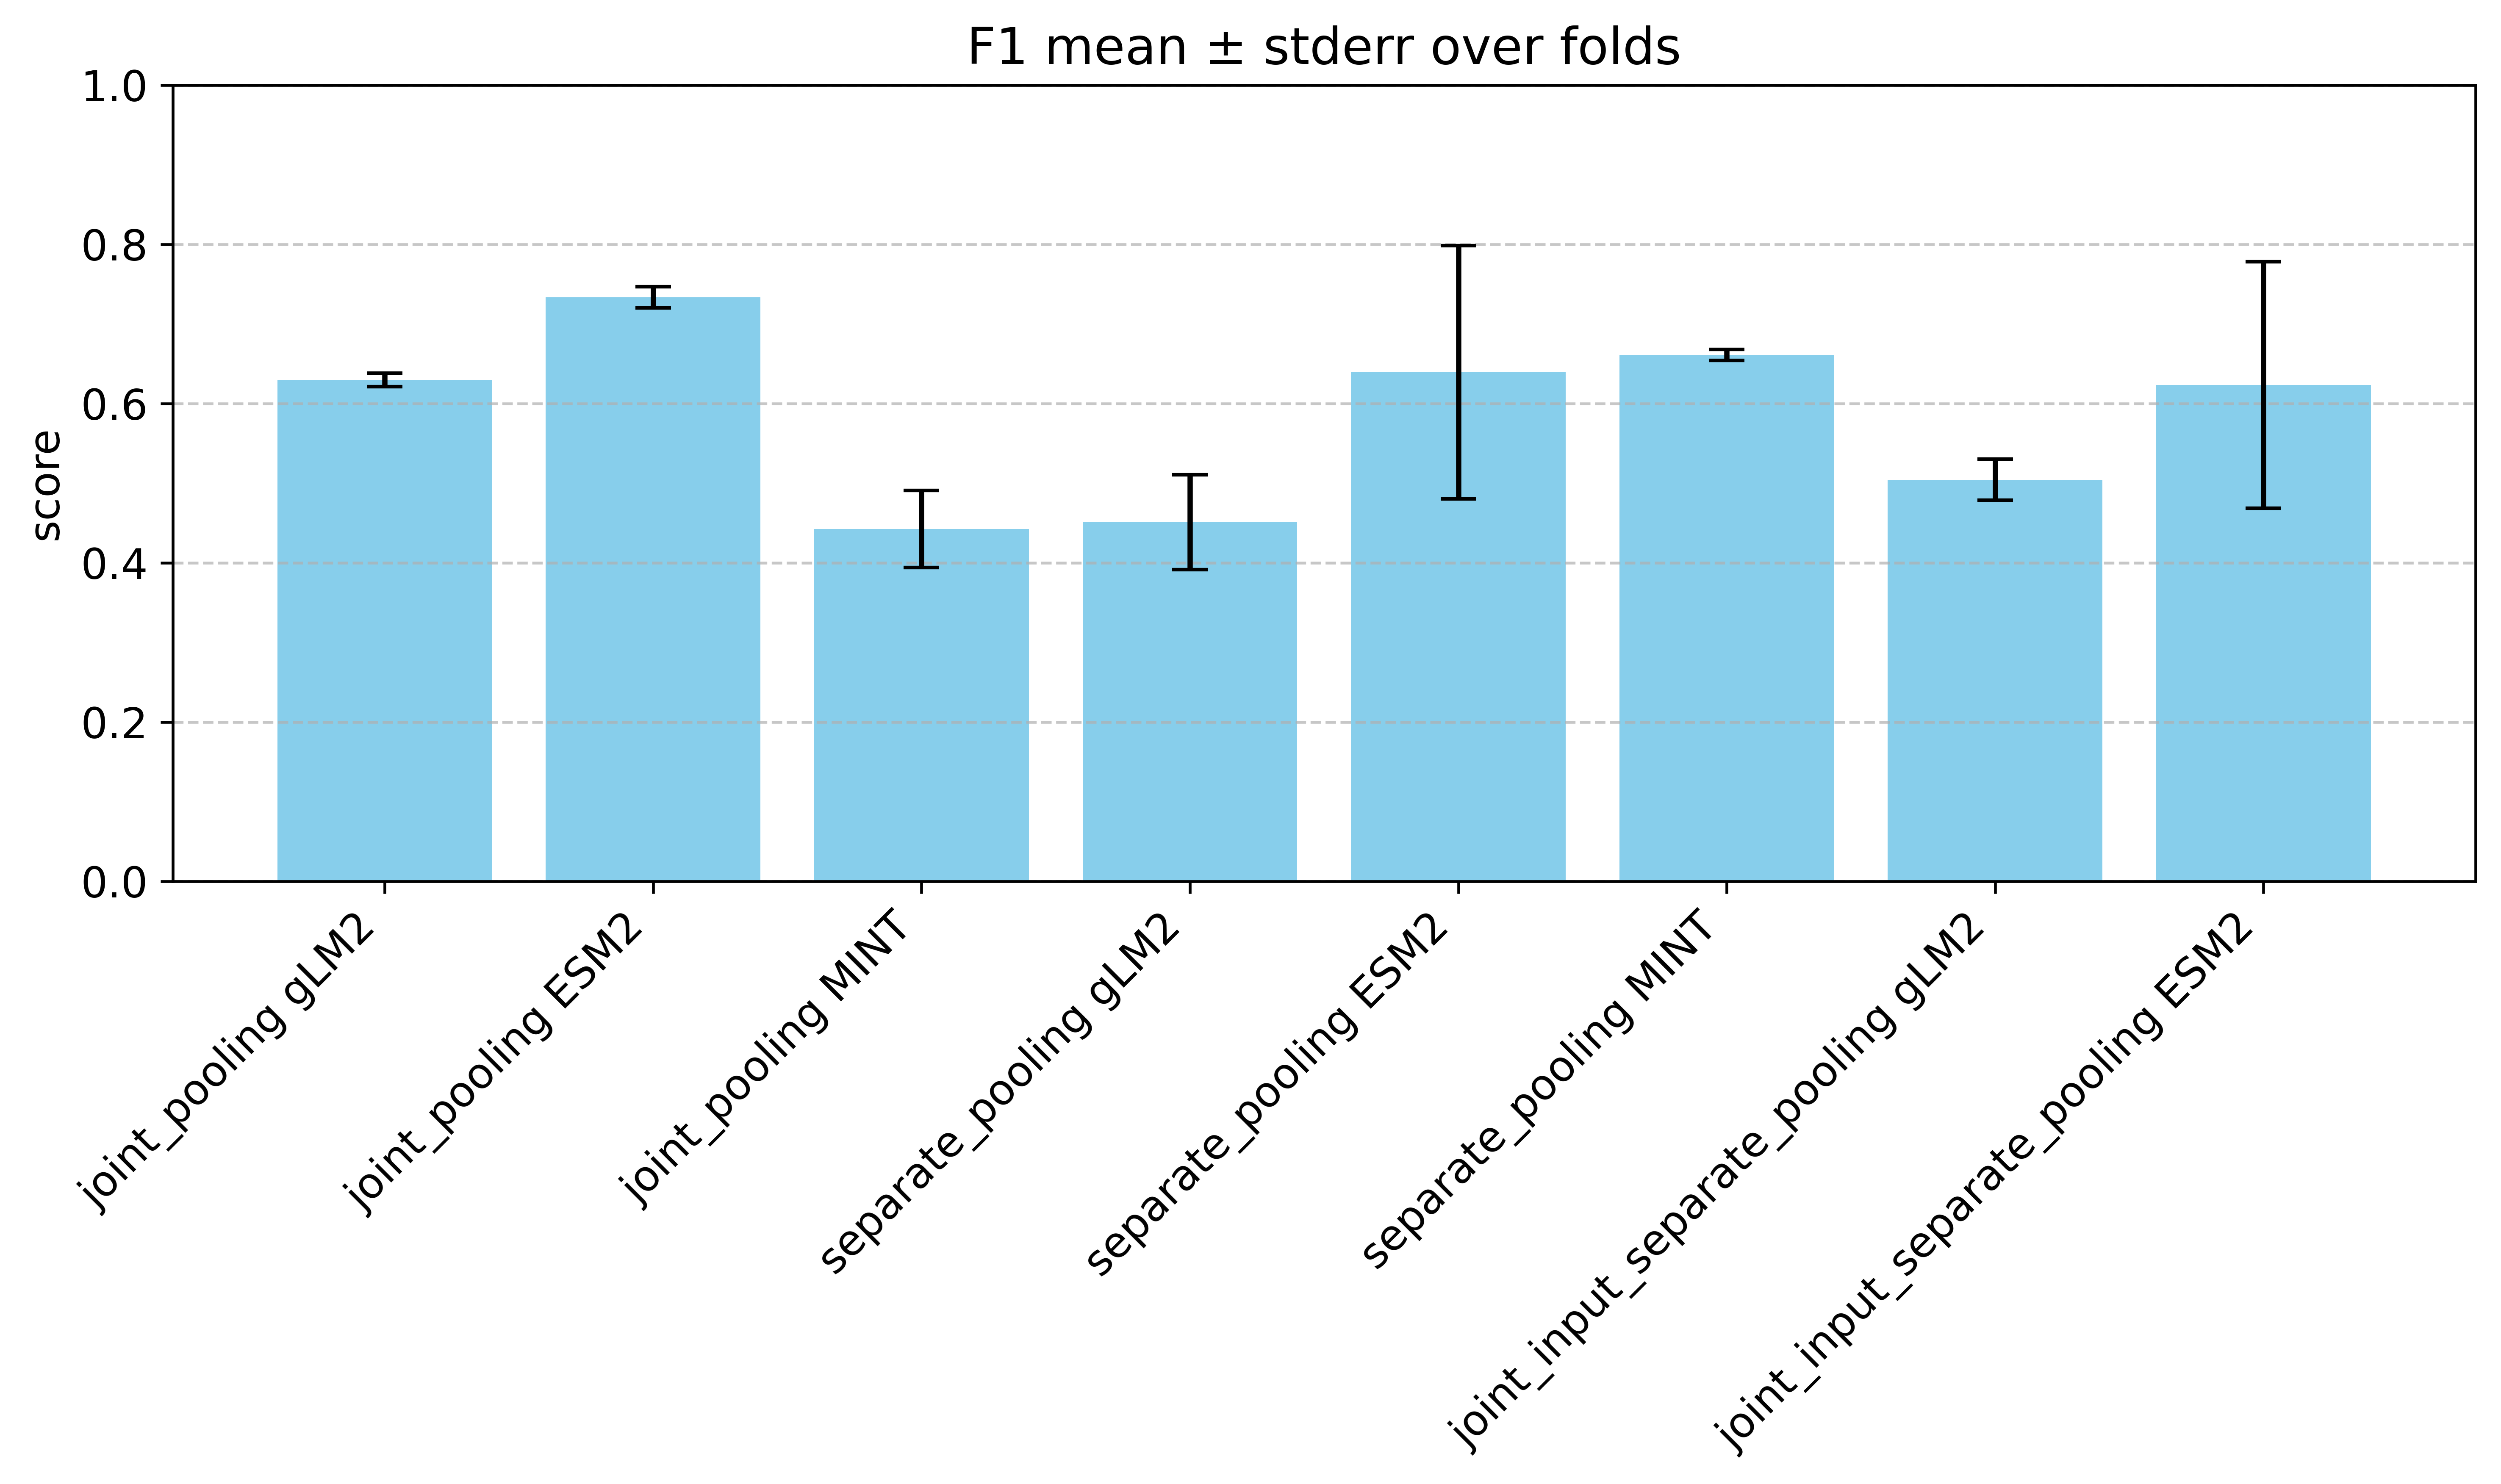

In [4]:
import matplotlib as mpl

mpl.rcParams['figure.dpi'] = 600
mpl.rcParams.update({'font.size': 12})

if not os.path.exists(output_dir): os.makedirs(output_dir)

df = initialise_df(representations, biolms, num_folds)

for metric_of_interest in ["mcc", "pr_auc", "roc_auc", "accuracy", "f1", "tn", "fp", "fn", "tp"]:
    results, epochs, metrics_arr, best_epochs_arr = get_metric_of_interest_values(representations, biolms, metric_of_interest, num_folds)
    df["best_epoch"] = best_epochs_arr
    df[metric_of_interest] = metrics_arr
    if(metric_of_interest not in ["tn", "fp", "fn", "tp"]):
        means, stderrs, labels = get_performance_stats(results)
        plot_stats(means, stderrs, labels, metric_of_interest, output_dir)

df.to_csv(f"{output_dir}/metrics.csv", index=False)